# 公司生命周期

## 加载模块

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import mstats

## 读入文件

_Warning: `df_stock['SICCD'] == 'Z'` 的情况将值转换为 -1_

_Warning: `df_stock['DLRET'].isin(['S', 'P', 'T'])` 的情况将值转换为 nan_

_Warning: `df_stock['RET'] == 'C'` 的情况将值转换为 0_

In [2]:
df_stock = pd.read_csv('../data/stock-monthly.csv', dtype={'SICCD': object, 'DLRET': object, 'RET': object})
df_stock['SICCD'] = df_stock['SICCD'].replace('Z', -1).astype(int)
df_stock['DLRET'] = df_stock['DLRET'].replace(['S', 'P', 'T'], np.nan).astype(float)
df_stock['RET'] = df_stock['RET'].replace('C', 0.).astype(float)
df_acc = pd.read_csv('../data/accounting-annual.csv')

初步处理

In [3]:
coms = df_stock['PERMNO'].unique()
print(f'公司样本数: {coms.size}')
df_acc = df_acc[df_acc['LPERMNO'].isin(coms)]
df_acc = df_acc.sort_values(by=['LPERMNO', 'fyear'])

df_stock['date'] = pd.to_datetime(df_stock['date'])
df_acc['datadate'] = pd.to_datetime(df_acc['datadate'])

公司样本数: 15320


## 定义公司周期

_Warning: 等于 0 的现金流按照大于 0 处理_

In [4]:
def life_cycle_stage(acc):
    '''
    根据现金流符号定义公司周期阶段
    acc: accounting information
    oancf: 经营活动现金流
    ivncf: 投资活动现金流
    fincf: 筹资活动现金流
    等于 0 的现金流按照大于 0 处理
    '''
    map_oif_2_stg = {(-1, -1, 1): 'Intro', (1, -1, 1): 'Growth', (1, -1, -1): 'Mature',
                     (-1, -1, -1): 'Shakeout', (1, 1, 1): 'Shakeout', (1, 1, -1): 'Shakeout',
                     (-1, 1, 1): 'Decline', (-1, 1, -1): 'Decline'}
    oif = np.sign([acc['oancf'], acc['ivncf'], acc['fincf']])
    # if (np.any(np.isnan(oif))):
    #     return 'Unknown'
    # oif[np.where(oif == 0.)] = 1.
    if np.any(np.isnan(oif)) or np.any(oif == 0):
        return 'Unknown'
    return map_oif_2_stg[tuple(oif)]

In [5]:
accounting_year = np.arange(1987, 2023)
stg = df_acc.apply(life_cycle_stage, axis=1)
df_acc['stg'] = stg

### EXHIBIT2

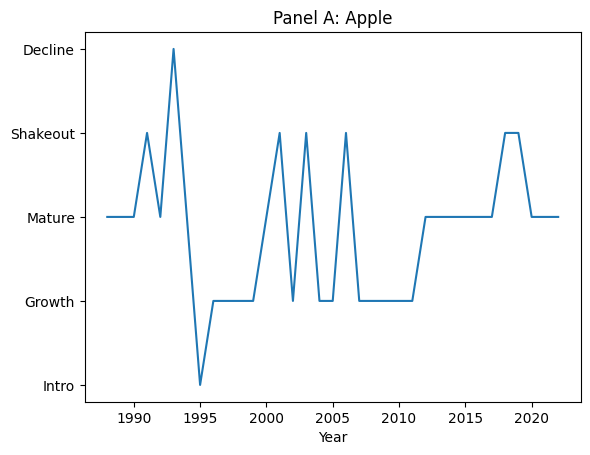

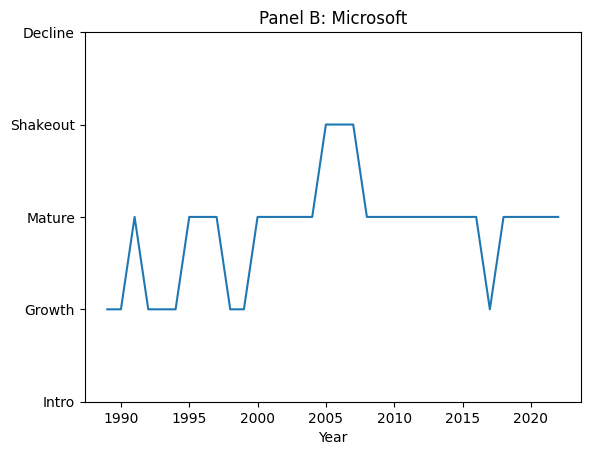

In [6]:
index_stg = ['Intro', 'Growth', 'Mature', 'Shakeout', 'Decline']
map_stg_2_num = {stg: num for stg, num in zip(index_stg, range(5))}

stg_apple = df_acc[df_acc['conm'] == 'APPLE INC']['stg']
stg_microsoft = df_acc[df_acc['conm'] == 'MICROSOFT CORP']['stg']
stg_num_apple = stg_apple.apply(map_stg_2_num.get)
stg_num_microsoft = stg_microsoft.apply(map_stg_2_num.get)

plt.plot(accounting_year, stg_num_apple)
plt.gca().set_yticks(range(5))
plt.gca().set_yticklabels(index_stg)
plt.xlabel('Year')
plt.title('Panel A: Apple')
plt.savefig('../exhibits/Exhibit2-PanelA.png')
plt.show()

plt.plot(accounting_year, stg_num_microsoft)
plt.gca().set_yticks(range(5))
plt.gca().set_yticklabels(index_stg)
plt.xlabel('Year')
plt.title('Panel B: Microsoft')
plt.savefig('../exhibits/Exhibit2-PanelB.png')
plt.show()

## 计算公司特征量

### 计算市值

首先还需要对退市股价、退市收益率进行处理

需要注意 'PRC' 有正负号，需要取绝对值

| variable    | unit     |
|-------------|----------|
| PRC         | 1        |
| SHROUT      | thousand |
| RET         | 1        |
| market-cap  | billion  |
| past-return | 1        |

In [7]:
df_stock['CFACPR'] = df_stock['CFACPR'].replace(0, np.nan)
df_stock['CFACPR'] = df_stock['CFACPR'].ffill()
idx_prc_na = df_stock['PRC'].isna()
df_stock['adj-prc'] = 0

df_stock['adj-prc'] = df_stock['PRC'].apply(abs)# / df_stock['CFACPR']
df_stock.loc[idx_prc_na, 'adj-prc'] = df_stock.loc[idx_prc_na, 'DLPRC'].apply(abs)
df_stock.loc[idx_prc_na, 'RET'] = df_stock.loc[idx_prc_na, 'DLRET']

df_stock['market-cap'] = df_stock['adj-prc'] * df_stock['SHROUT'] * 1e3 / 1e9

### 计算历史收益率 

In [8]:
def past_return_calc(ret):
    growth_log = (1 + ret).apply(np.log)
    growth_log_11 = growth_log.shift(2).rolling(window=11).sum()
    return np.exp(growth_log_11) - 1

df_stock['past-return'] = df_stock.groupby('PERMNO', group_keys=False)['RET'].apply(past_return_calc)

### 计算账面权益、盈利能力、投资水平、债务权益比

填补缺失值

_Warning: 如果 `pstkl`, `pstk` 都缺失，则把 `pstkrv` 替换为 0_

| variable      | unit               |
|---------------|--------------------|
| at            | million -> billion |
| txdb          | million            |
| pstkrv        | million            |
| pstkl         | million            |
| pstk          | million            |
| teq           | million            |
| revt          | million            |
| cogs          | million            |
| xsga          | million            |
| tie           | million            |
| book-equity   | billion            |
| debt-to-quity | 1                  |
| profit        | million            |
| investment    | billion            |

In [9]:
df_acc['txdb'] = df_acc['txdb'].fillna(0)
df_acc['pstkrv'] = df_acc['pstkrv'].fillna(df_acc['pstkl'])
df_acc['pstkrv'] = df_acc['pstkrv'].fillna(df_acc['pstk'])
df_acc['pstkrv'] = df_acc['pstkrv'].fillna(0)
df_acc['teq'] = df_acc['teq'].fillna(df_acc['pstk'] + df_acc['ceq'])
df_acc['teq'] = df_acc['teq'].fillna(df_acc['at'] - df_acc['lt'])
df_acc['tie'] = df_acc['tie'].fillna(0)

In [10]:
df_acc['book-equity'] = (df_acc['teq'] - df_acc['pstkrv'] + df_acc['txdb'])
df_acc.loc[df_acc['book-equity'] <= 0, 'book-equity'] = np.nan
df_acc['debt-to-equity'] = df_acc['lt'] / df_acc['teq']
df_acc['profit'] = (df_acc['revt'] - df_acc['cogs']
                    - df_acc['xsga'] - df_acc['tie']) / df_acc['book-equity']
df_acc['investment'] = df_acc.groupby('LPERMNO')['at'].diff()
df_acc[['at', 'book-equity', 'investment']] = df_acc[['at', 'book-equity', 'investment']] / 1e3

### 合并 `df_stock` 与 `df_acc`

~~使用 6 个月以前的最新的财报数据~~

~~_Warning: 公司在 1989 年的前几个月，可能没有 6 个月前的财报数据，通过采用表格中最老的数据 (1988 年) 来解决。比较好的解决方法可能是下载从 1987 开始的数据_~~

使用股票数据时间年份 - 1 年的财报数据

注意：`df_acc` 中，存在一个财年两份财报的状况，暂时保留全部两份，可以视情况采用后一份财报

In [11]:
# df_stock['date_6_month'] = df_stock['date'] - pd.DateOffset(months=6)
# first_records = df_acc.groupby('LPERMNO').first()[['fyear', 'stg']]

# df_merge = pd.merge_asof(
#     df_stock.sort_values(['date_6_month']),
#     df_acc.sort_values(['datadate']),
#     left_on='date_6_month',
#     right_on='datadate',
#     left_by='PERMNO',
#     right_by='LPERMNO',
#     direction='backward'
# )
# mask = df_merge['fyear'].isna()
# df_merge.loc[mask, 'fyear'] = df_merge.loc[mask, 'PERMNO'].map(first_records['fyear'])
# df_merge.loc[mask, 'stg'] = df_merge.loc[mask, 'PERMNO'].map(first_records['stg'])

# df_merge = df_merge.sort_values(['PERMNO', 'date'])
# df_merge.loc[df_merge['PERMNO'] <= 10007, ['PERMNO', 'date', 'datadate', 'fyear', 'stg']]

In [12]:
df_stock['fyear'] = df_stock['date'].dt.year - 1

df_merge = pd.merge(
    df_stock,
    df_acc,
    left_on=['PERMNO', 'fyear'],
    right_on=['LPERMNO', 'fyear'],
    how='left'
)
# df_merge = df_merge[df_merge['book-equity'] >= 0]
# df_merge = df_merge.groupby(['PERMNO', "date"]).last().reset_index()

### 计算账面市值比

| variable       | unit |
|----------------|------|
| book-to-market | 1    |

In [13]:
df_merge['book-to-market'] = df_merge['book-equity'] / df_merge['market-cap']

### 保存新文件

In [14]:
reserved_columns = ['PERMNO', 'COMNAM', 'date', 'fyear', 'stg', 'adj-prc', 'RET',
                    'book-equity', 'profit', 'investment', 'past-return',
                    'market-cap', 'at', 'book-to-market', 'debt-to-equity']
df_merge = df_merge[reserved_columns]
df_merge.to_csv('../data/stock-accounting.csv')

### EXHIBIT 4

In [17]:
def mean_wins(x):
    x_wins = x.dropna()
    x_wins = mstats.winsorize(x_wins, [0.01, 0.01])
    return x_wins.mean()
def std_wins(x):
    x_wins = x.dropna()
    x_wins = mstats.winsorize(x_wins, [0.01, 0.01])
    return x_wins.std()

sum_stat = ['market-cap', 'at', 'book-to-market', 'debt-to-equity',
            'profit', 'investment', 'past-return']
df_sum_stat = pd.DataFrame(columns=index_stg)
for ss in sum_stat:
    df_sum_stat.loc[ss + '-mean'] = df_merge.groupby('stg')[ss].apply(mean_wins)
    df_sum_stat.loc[ss + '-std'] = df_merge.groupby('stg')[ss].apply(std_wins)
df_sum_stat.to_csv('../exhibits/Exhibit4.csv')
pd.options.display.float_format = '{:.2f}'.format
df_sum_stat

,Intro,Growth,Mature,Shakeout,Decline
market-cap-mean,0.31,1.99,4.70,2.04,0.27
market-cap-std,0.83,5.64,15.05,7.14,0.69
at-mean,0.26,1.88,3.57,1.98,0.27
at-std,0.74,5.15,10.11,6.29,0.89
book-to-market-mean,0.75,0.74,0.79,1.02,0.87
book-to-market-std,1.12,0.94,0.97,1.46,1.27
debt-to-equity-mean,1.24,1.60,1.44,1.61,0.92
debt-to-equity-std,4.17,2.80,3.20,4.48,4.57
profit-mean,-0.40,0.28,0.37,0.16,-0.54
profit-std,1.28,0.29,0.42,0.50,1.25


## EXHIBIT 3

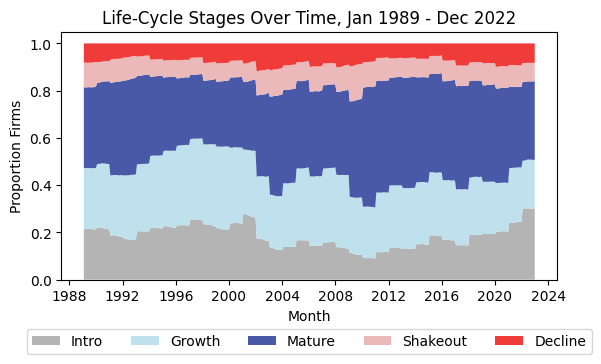

In [16]:
time_series = df_merge['date'].sort_values().unique()
df_frac = pd.DataFrame(time_series, columns=['date'])

count = df_merge[df_merge['stg'] != 'Unknown'].groupby('date').count()
df_frac['Total'] = df_frac['date'].map(count['stg'])
for stage in index_stg:
    stg_count = df_merge[df_merge['stg'] == stage].groupby('date').count()
    df_frac[stage] = df_frac['date'].map(stg_count['stg'])
    df_frac[stage] = df_frac[stage] / df_frac['Total']
frac_values = [df_frac[stage] for stage in index_stg]

colors = ['#b4b4b5', '#bee1ed', '#4959a7', '#ebb9ba', '#ef3c39']
plt.stackplot(time_series, frac_values, labels=index_stg, colors=colors)
plt.title('Life-Cycle Stages Over Time, Jan 1989 - Dec 2022')
plt.xlabel('Month')
plt.ylabel('Proportion Firms')
plt.gca().set_box_aspect(0.5)
plt.legend(ncols=5, loc=[-0.07, -0.3])
plt.savefig('../exhibits/Exhibit3.png')
plt.show()